In [48]:
import pandas as pd
import numpy as np
import os
import copy
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats.stats import pearsonr
from scipy.stats import chi2_contingency
import statsmodels.api as sm

# Predictive Analysis with Multiple Linear Regression

## Table of Contents

1. Introduction
2. Basic Exploration Examples
   1. Survival-Related Outcome Variables
      1. Sexual Health and Reproduction
      2. Sleep  
   2. Quality of Life-Related Outcome Variables
3. Multiple Linear Regressions
    1. Capturing Correlation
    2. Creating a Model

## 1. Introduction

For this project, multiple methods were tested for their ability to create a model with some predictive utility. This notebook outlines and summarizes the attempt to use multiple linear regression (ordinary least squares (OLS) method). The notebook will go through some of the code that was used to explore the data and its appropriateness for this method, discuss various outcome variables (which were used, which were discarded, and why), and finally, the the construction of a regression model that aims to predict a patient's likliehood of experiencing depression.

## 2. Basic Exploration Examples

### 2 A. Survival-Related Outcome Variables

Innitially, variables were investigated for their potential usefulness in predicting survivorship. This approach was problematic because there are few participants in the data set who have not survived. Some relationships were examined between possible predictor variables and time survived since diagnosis, but ultimately this outcome variable was not useful. The data simply contains too few cases of patients who have died; because time survivied since diagnosis is based overwhelmingly on living patients, it is really just measuring time since diagnosis. While this may itself be an interesting variable to examine, it does not capture lillihood of survival.

In [13]:
# read in the data
baseline = pd.read_csv("/baseline.csv", engine='python')

clinical_full = pd.read_csv("/clinical.csv", engine='python', infer_datetime_format=True, 
                            parse_dates = ['DateOfBirth_Shifted_Date', 'DateOfDeath_Shifted_Date',
                                           'Dx1DateOfDiagnosis_Shifted_Date'])

outcomes = clinical_full[['PatientCaseId', 'DateOfBirth_Shifted_Date', 'DateOfDeath_Shifted_Date',
                          'Dx1DateOfDiagnosis_Shifted_Date', 'Dx1DxDatePrecision', 
                          'Dx1DxDateEstimated']]

print (outcomes['Dx1DxDatePrecision'].value_counts())
print (outcomes['Dx1DxDateEstimated'].value_counts())
print (outcomes['DateOfDeath_Shifted_Date'].value_counts())
# based on the above, 41 participants have died but not all of these deaths are useful:

# there are 13 diagnosis dates that are specific only to the year
# drop these cases and look at the survival times in months
# for now, ignore whether or not a date is estimated
# the number of estimates may drop when the imprecise dates are dropped:
outcomes = outcomes[outcomes.Dx1DxDatePrecision != 1.0]

# drop the observation with 'unknown' for death date
outcomes = outcomes[outcomes.DateOfDeath_Shifted_Date != 'Unknown']

3.0    709
2.0    112
1.0     13
Name: Dx1DxDatePrecision, dtype: int64
False    793
True      41
Name: Dx1DxDateEstimated, dtype: int64
Unknown            39
3/13/2018 0:00      1
6/4/2018 0:00       1
6/30/2014 0:00      1
8/16/2018 0:00      1
12/24/2016 0:00     1
8/30/2017 0:00      1
1/23/2019 0:00      1
1/27/2015 0:00      1
11/20/2014 0:00     1
3/12/2016 0:00      1
8/21/2016 0:00      1
10/23/2018 0:00     1
8/20/2019 0:00      1
8/7/2015 0:00       1
12/6/2017 0:00      1
4/11/2019 0:00      1
7/17/2019 0:00      1
8/7/2016 0:00       1
9/13/2016 0:00      1
6/27/2016 0:00      1
5/2/2018 0:00       1
4/28/2017 0:00      1
1/3/2016 0:00       1
6/22/2019 0:00      1
5/28/2018 0:00      1
Name: DateOfDeath_Shifted_Date, dtype: int64


In [14]:
print (outcomes['Dx1DxDatePrecision'].value_counts())
print (outcomes['Dx1DxDateEstimated'].value_counts())
print (outcomes['DateOfDeath_Shifted_Date'].value_counts())
# 7 of the year-only dates were flagged as estimates

outcomes.DateOfDeath_Shifted_Date = pd.to_datetime(outcomes.DateOfDeath_Shifted_Date, 
                                                   errors='coerce')
# truncate the date of diagnosis to month, so the precision 1 and 2 will be the same
# this may not be ideal but, for now, allows us to consider the greatest number of deaths

outcomes['Dx1DateOfDiagnosis_Year_Month'] = pd.to_datetime(outcomes['Dx1DateOfDiagnosis_Shifted_Date']).dt.to_period('M')

outcomes.head()

# calculate the time survived since diagnosis
# using current UTC time or time of death
def months_survived(dx_date, end_date):
    if (pd.isna(end_date)):
        dt = datetime.utcnow()
        end_date = dt
    time_survived = end_date - dx_date
    return time_survived

outcomes['time_survived'] = outcomes.apply(lambda outcomes: 
                                           months_survived(outcomes.Dx1DateOfDiagnosis_Shifted_Date, 
                                                           outcomes.DateOfDeath_Shifted_Date), axis=1)

# make a column with total seconds survived, for easier calculation
outcomes['seconds_survived'] = outcomes.apply(lambda x: x.time_survived.total_seconds(), axis=1)

#outcomes.to_csv('outcomes.csv', index=False)

3.0    678
2.0    105
Name: Dx1DxDatePrecision, dtype: int64
False    751
True      32
Name: Dx1DxDateEstimated, dtype: int64
3/13/2018 0:00     1
6/4/2018 0:00      1
6/30/2014 0:00     1
8/16/2018 0:00     1
12/24/2016 0:00    1
8/30/2017 0:00     1
1/23/2019 0:00     1
1/27/2015 0:00     1
11/20/2014 0:00    1
3/12/2016 0:00     1
8/21/2016 0:00     1
10/23/2018 0:00    1
8/20/2019 0:00     1
8/7/2015 0:00      1
12/6/2017 0:00     1
4/11/2019 0:00     1
7/17/2019 0:00     1
8/7/2016 0:00      1
9/13/2016 0:00     1
6/27/2016 0:00     1
5/2/2018 0:00      1
4/28/2017 0:00     1
1/3/2016 0:00      1
6/22/2019 0:00     1
5/28/2018 0:00     1
Name: DateOfDeath_Shifted_Date, dtype: int64


#### 2 A1. Sexual Health and Reproduction

The Sexual Health and Reproduction Section includes several gendered questions and other unique fields that require some manipulation.

In [15]:
#baseline_full = pd.read_csv("baseline.csv", engine='python')
#outcomes = pd.read_csv("outcomes.csv", engine='python')

# there are two questions that were asked separately of men and women
# although the questions were identical
# for the purposes of this analysis, combine these columns

# make a couple of fields that combine the two gendered questions
def combine_cols(female_ans, male_ans):
    if (pd.notnull(male_ans)):
        ans = male_ans
    else:
        ans = female_ans
    return ans

baseline['difficulty_orgasm'] = baseline.apply(lambda baseline: combine_cols(baseline.RH_F_9A_F_4_AnsVal, baseline.RH_M_9G_L_4_AnsVal), axis=1)
baseline['lack_of_interest'] = baseline.apply(lambda baseline: combine_cols(baseline.RH_F_9A_F_3_AnsVal, baseline.RH_M_9G_L_5_AnsVal), axis=1)

# double check that no one answered both the men's and women's questions
print (baseline['RH_F_9A_F_4_AnsVal'].value_counts())
print (baseline['RH_M_9G_L_4_AnsVal'].value_counts())
print (baseline['difficulty_orgasm'].value_counts())

5.0    200
4.0     68
2.0     55
3.0     48
1.0     48
Name: RH_F_9A_F_4_AnsVal, dtype: int64
5.0    105
1.0     14
4.0     11
3.0      8
2.0      7
Name: RH_M_9G_L_4_AnsVal, dtype: int64
5.0    305
4.0     79
2.0     62
1.0     62
3.0     56
Name: difficulty_orgasm, dtype: int64


In [16]:
# check the columns to see which are potentially worth examining
# this section is provided as an example and has been truncated

# baseline.shape 756 total observations

#print (baseline['RH_4'].value_counts())
# only has two 9999, should be 28 nulls, so 726 good observations

#print (baseline['RH_5'].value_counts())
# has 226 7777, and must be 28 nulls, so only 502 good observations

#print (baseline['RH_8a_1_AnsVal'].value_counts())
# 665 good rows, pretty decent spread, only 23 5.0

#print (baseline['RH_8a_2_AnsVal'].value_counts())
# 661 good rows, but only 6 responses in 5.0 category. otherwise spread is def sufficient

print (baseline['RH_7'].value_counts())
# 628 good responses with ok dist, some categories low like 18, 19, 20.
# includes 99 9999s, so must be 29 null

0.0       198
9999.0     99
10.0       76
8.0        75
5.0        63
7.0        59
9.0        41
6.0        38
1.0        21
2.0        20
3.0        19
4.0        18
Name: RH_7, dtype: int64


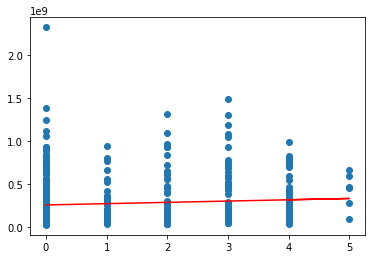

Coefficients: 
 [[15025996.42935329]]
Mean squared error: 72416966427947968.00
Coefficient of determination: 0.01


In [19]:
# join with outcomes
# recall that some observations were dropped from outcomes
data = pd.merge(baseline, outcomes, on='PatientCaseId')

# this is modeling freq. of intercourse past month -> secobds survived since diagnosis
data2 = data[['RH_8a_2_AnsVal', 'seconds_survived']]
data2 = data2.dropna()

X = data2['RH_8a_2_AnsVal'].values.reshape(-1, 1)
Y = data2['seconds_survived'].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Y, Y_pred))
# The coefficient of determination: 0.01
print('Coefficient of determination: %.2f'
      % r2_score(Y, Y_pred))

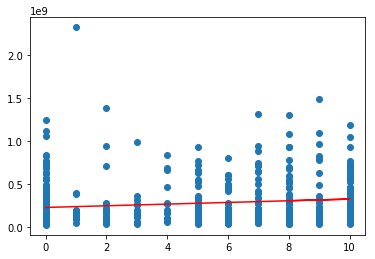

Coefficients: 
 [[9729595.97089121]]
Mean squared error: 71833866876998856.00
Coefficient of determination: 0.02


In [20]:
# this is modeling extent to which sexual activity is satisfying -> seconds survived since diagnosis

data5 = data[['RH_7', 'seconds_survived']]
data5 = data5.dropna()
data5 = data5[data5.RH_7 != 9999.0]

#data5 = data5[data5.RH_7 != 0.0]

X = data5['RH_7'].values.reshape(-1, 1)
Y = data5['seconds_survived'].values.reshape(-1, 1)
clf = Ridge(alpha=1.0)
clf.fit(X, Y)
Y_pred = clf.predict(X)

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

# The coefficients
print('Coefficients: \n', clf.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Y, Y_pred))
# The coefficient of determination: .02
print('Coefficient of determination: %.2f'
      % r2_score(Y, Y_pred))

# several other models were tried and all were similarly unenlightening
# as described above, this outcome variable was discarded

#### 2 A2. Sleep¶

In [21]:
# subset the sleep-related variables
# choose a few that have a good response rate and reasonable good distribution

baseline_sleep = baseline[['Sleep_1', 'ISQ_2-7_1_AnsVal', 'ISQ_2-7_2_AnsVal',
                         'ISQ_2-7_3_AnsVal', 'ISQ_2-7_4_AnsVal', 'ISQ_2-7_5_AnsVal',
                         'ISQ_2-7_6_AnsVal', 'PatientCaseId']]

data = pd.merge(baseline, outcomes, on='PatientCaseId')

7.0     213
8.0     137
6.0     117
9.0      41
5.0      40
4.0      19
10.0     13
3.0       2
2.0       1
Name: Sleep_1, dtype: int64


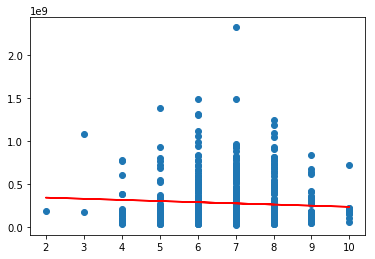

In [22]:
# modelling hours slept per night on seconds survived

data2 = data[['Sleep_1', 'seconds_survived']]
data2 = data2.dropna()
data2 = data2[data2.Sleep_1 != 9999.0]

print (data2['Sleep_1'].value_counts())

X = data2['Sleep_1'].values.reshape(-1, 1)
Y = data2['seconds_survived'].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

This plot suggests there is a potentially interesting but non-linear relationship here. Because this outcome was dropped as a variable of interest, this relationship was not examined further.

### 2 B. Quality of Life-Related Outcome Variables

When survival-related outcome variables were deemed innapropriate for this dataset, quality of life-related outcomes were slected for examination on the basis of their usefulness to patients and clinicians. Both patients and treating physicians want not only long term survival, but also long term happiness, sexual satisfaction, adequate sleep, and reduced pain. Flags that help predict this outcomes are useful for everyone.

Following are some of the simple explorations of various predictors on quality of life-related outcomes. No single linear regression comprised, by itself, a useful model. This was expected. However, several plots did indicate the presence of correllations worth further investigation.

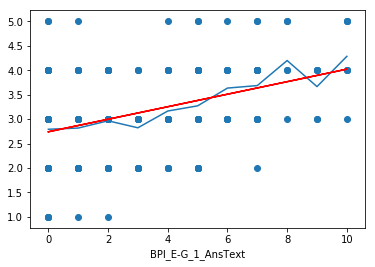

Coefficients: 
 [[0.12814759]]
Mean squared error: 0.65
Coefficient of determination: 0.17


In [23]:
# pain interferes with relationships with others -> perceived general health

sub_1 = baseline[['BPI_E-G_1_AnsText', 'SF-36_1']]
sub_1 = sub_1.dropna()
sub_1 = sub_1[sub_1['BPI_E-G_1_AnsText'] != 9999.0]
sub_1 = sub_1[sub_1['BPI_E-G_1_AnsText'] != 7777.0]
sub_1 = sub_1[sub_1['BPI_E-G_1_AnsText'] != 9999.0]

X = sub_1['BPI_E-G_1_AnsText'].values.reshape(-1, 1)
Y = sub_1['SF-36_1'].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

avg = sub_1.groupby('BPI_E-G_1_AnsText')['SF-36_1'].agg('mean')
avg.plot()

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)
# The mean squared error: 0.65
print('Mean squared error: %.2f'
      % mean_squared_error(Y, Y_pred))
# The coefficient of determination: 0.17
print('Coefficient of determination: %.2f'
      % r2_score(Y, Y_pred))

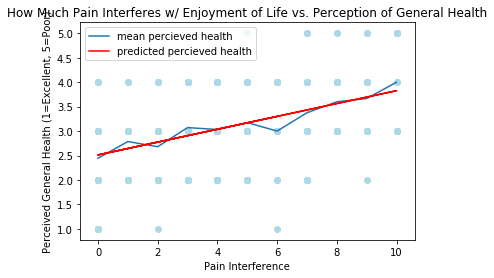

Coefficients: 
 [[0.1315021]]
Mean squared error: 0.61
Coefficient of determination: 0.21


In [24]:
# how much pain interferes with your enjoyment of life -> in general how is your health

sub_1 = data[['BPI_E-G_3_AnsText', 'SF-36_1']]
sub_1 = sub_1.dropna()
sub_1 = sub_1[sub_1['BPI_E-G_3_AnsText'] != 9999.0]
sub_1 = sub_1[sub_1['BPI_E-G_3_AnsText'] != 7777.0]
sub_1 = sub_1[sub_1['BPI_E-G_3_AnsText'] != 9999.0]

X = sub_1['BPI_E-G_3_AnsText'].values.reshape(-1, 1)
Y = sub_1['SF-36_1'].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

avg = sub_1.groupby('BPI_E-G_3_AnsText')['SF-36_1'].agg('mean')
avg.plot(label = 'mean percieved health')

plt.scatter(X, Y, color='lightblue')
plt.plot(X, Y_pred, color='red', label='predicted percieved health')
#plt.plot(X_mean, color='blue')

plt.title('How Much Pain Interferes w/ Enjoyment of Life vs. Perception of General Health')
plt.xlabel('Pain Interference')
plt.ylabel('Perceived General Health (1=Excellent, 5=Poor)')
plt.legend(loc="upper left")
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)
# The mean squared error: 0.61
print('Mean squared error: %.2f'
      % mean_squared_error(Y, Y_pred))
# The coefficient of determination: 0.2
print('Coefficient of determination: %.2f'
      % r2_score(Y, Y_pred))

## 3. Multiple Linear Regressions

Several models were constructed using multiple linear regression to predict various quality of life-related outcomes using highly correlated variables from elsewhere in the dataset. 

First, the correlation between each variable in the Quality of Life section of the baseline survey to each other variable in the dataset was captured. To do this, the Quality of Life variables were divided into categorical and continuous groups. (Several discrete variables were included in both groups and ultimately tested in models where they were treated as categorical and models where they were treated as continuous. This was done because several questions ask respondents to rate something on a scale, to provide the number of hours something lasted, or to provide the number of instances of some event. In these cases, although the numbers are discrete, they are real numbers and the intervals between them have real meaning. Finding a best fitting regression line does make logical sense, and initial investigations did suggest that some of these discrete variables had potentially linear relationships to various outcomes. On the other hand, some sources suggest that treating discrete variables as continuous is a bad pracice when the values can be close to 0; in this data set, values can be close to 0 and in some cases 0 itself. For this reason, both methods were tried and differences observed).

Second, models were made using forward selection: variables were added to models one at a time, beginning with the most strongly correlated, then proceeding to the next most strongly correlated, etc. Before a predictor was added to a model, it was confirmed that the particular statistic for measuring correlation was appropriate for that variable and its distribution and response rate were checked. Many apparently highly-correlated variables were discarded because they had an extremely low response rate, and the high correlation was simply an artifact of that. During this process variables were also discarded (i.e. not added to the model) if they were too strongly interralted to variables already included. For example, there are several questions in various sections of the survey which all essentially ask about depression and depressive symptoms. It is not appropriate to use all of these highly related, and absolutely not independent, variables as predictors in one model.

### 3 A. Capturing Correlation

In [42]:
# make a lists of all the outcome variables
# some are in both categories; observe what works

outcome_vars_categorical_list = ['PatientCaseId','SF-36_1','SF-36_2','SF-36_3','SF-36_4','SF-36_5','SF-36_6','SF-36_7',
                'SF-36_9','SF-36_10','SF-36_11','SF-36_12','SF-36_13','SF-36_14','SF-36_15',
                'SF-36_16','SF-36_17','SF-36_18','SF-36_19','SF-36_20','SF-36_21','SF-36_22',
                'SF-36_23','SF-36_24','SF-36_25','SF-36_26','SF-36_27','SF-36_28','SF-36_29',
                'SF-36_30','SF-36_31','SF-36_32']

outcome_vars_categorical_list2 = ['SF-36_1','SF-36_2','SF-36_3','SF-36_4','SF-36_5','SF-36_6','SF-36_7',
                'SF-36_9','SF-36_10','SF-36_11','SF-36_12','SF-36_13','SF-36_14','SF-36_15',
                'SF-36_16','SF-36_17','SF-36_18','SF-36_19','SF-36_20','SF-36_21','SF-36_22',
                'SF-36_23','SF-36_24','SF-36_25','SF-36_26','SF-36_27','SF-36_28','SF-36_29',
                'SF-36_30','SF-36_31','SF-36_32']

# removed from categorical: ['SF-6_8']

outcome_vars_continuous_list = ['PatientCaseId','SF-36_3','SF-36_4','SF-36_5','SF-36_6','SF-36_7',
                'SF-36_9','SF-36_10','SF-36_11','SF-36_12','SF-36_13','SF-36_14','SF-36_15',
                'SF-36_16','SF-36_17','SF-36_18','SF-36_19','SF-36_23','SF-36_24','SF-36_25',
                'SF-36_26','SF-36_27','SF-36_28','SF-36_29','SF-36_30','SF-36_31',
                'SF-36_34','SF-36_35','SF-36_36','HC_37_1','HC_37_2','HC_37_3','HC_37_4',
                'HC_37_5','HC_37_6','HC_37_7','HC_37_8','HC_37_9','HC_38_1','HC_38_2',
                'HC_38_3','HC_38_4','HC_38_5','HC_38_6','HC_38_7','HC_38_8','HC_38_9','HC_38_10',
                'HC_38_11','HC_38_12','HC_38_13','HC_38_14','HC_38_15','HC_38_16']

outcome_vars_continuous_list2 = ['SF-36_3','SF-36_4','SF-36_5','SF-36_6','SF-36_7',
                'SF-36_9','SF-36_10','SF-36_11','SF-36_12','SF-36_13','SF-36_14','SF-36_15',
                'SF-36_16','SF-36_17','SF-36_18','SF-36_19','SF-36_23','SF-36_24','SF-36_25',
                'SF-36_26','SF-36_27','SF-36_28','SF-36_29','SF-36_30','SF-36_31',
                'SF-36_34','SF-36_35','SF-36_36','HC_37_1','HC_37_2','HC_37_3','HC_37_4',
                'HC_37_5','HC_37_6','HC_37_7','HC_37_8','HC_37_9','HC_38_1','HC_38_2',
                'HC_38_3','HC_38_4','HC_38_5','HC_38_6','HC_38_7','HC_38_8','HC_38_9','HC_38_10',
                'HC_38_11','HC_38_12','HC_38_13','HC_38_14','HC_38_15','HC_38_16']

# removed SF-36_33
# removed from continuous: ['SF-6_8' 'HC_37_10' 'HC_38_17']

In [30]:
# make separate dataframes for input and output variables

# read in full data
baseline_full = pd.read_csv("/baseline.csv", engine='python')

# make dataframes for the outcomes
outcome_vars_continuous = copy.deepcopy(baseline_full[outcome_vars_continuous_list])
outcome_vars_categorical = copy.deepcopy(baseline_full[outcome_vars_categorical_list])

baseline_full_2 = pd.read_csv("/baseline.csv", engine='python')

# make dataframe for inputs (everything else)

input_vars = baseline_full_2[baseline_full_2.columns[~baseline_full_2.columns.isin(outcome_vars_continuous_list2)]]
input_vars = input_vars[input_vars.columns[~input_vars.columns.isin(outcome_vars_categorical_list2)]]

In [31]:
data = pd.merge(input_vars, outcome_vars_continuous, on='PatientCaseId')

def runAllLinReg():
    df_results = pd.DataFrame(columns = ['predictor', 'outcome', 'r2'])
    i = 0
    for pred in list(input_vars.columns): 
        for out in outcome_vars_continuous_list2:
            #pred = the current predictor
            #out = the current outcome
            try:
                data_temp = copy.deepcopy(data[[pred, out]])
                data_temp = data_temp.dropna()
                data_temp = data_temp[data_temp[pred] != 9999.0]
                data_temp = data_temp[data_temp[pred] != 7777.0]
                data_temp = data_temp[data_temp[out] != 9999.0]
                data_temp = data_temp[data_temp[out] != 7777.0]
                r2 = runLinReg(data_temp, pred, out)
                row = {'predictor':[pred], 'outcome':[out], 'r2':[r2]}
                df2 = pd.DataFrame(row)
                #print(df2.head())
                #df2 = pd.DataFrame(pred, out, r2, columns=['predictor', 'outcome', 'r2'])
                df_results = df_results.append(df2)
                #print(df_results.head())
                #print("WORKED: " + out + " " + pred)
            except ValueError:
                #print("error: " + out + pred)
                break
    return df_results

# a function that produces the necessary satistic
def runLinReg(df, pred, out):
    X = df[pred].values.reshape(-1, 1)
    Y = df[out].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    r2 = r2_score(Y, Y_pred)
    return r2

In [32]:
test_df = runAllLinReg()
lin_regs_df = test_df[test_df.predictor != 'PatientCaseId']
lin_regs_df.head()
#lin_regs_df.to_csv('lin_regs.csv', index=False)

,predictor,outcome,r2
0,AUDIT-C_10,SF-36_3,0.029318
0,AUDIT-C_10,SF-36_4,0.026591
0,AUDIT-C_10,SF-36_5,0.014678
0,AUDIT-C_10,SF-36_6,0.029044
0,AUDIT-C_10,SF-36_7,0.031035


In [33]:
def runAllPPMC():
    df_results = pd.DataFrame(columns = ['predictor', 'outcome', 'PPMC', 'pval'])
    for pred in list(input_vars.columns): 
        for out in outcome_vars_continuous_list2:
            try:
                data_temp = copy.deepcopy(data[[pred, out]])
                data_temp = data_temp.dropna()
                data_temp = data_temp[data_temp[pred] != 9999.0]
                data_temp = data_temp[data_temp[pred] != 7777.0]
                data_temp = data_temp[data_temp[out] != 9999.0]
                data_temp = data_temp[data_temp[out] != 7777.0]               
                ppmc, pval = runPPMC(data_temp, pred, out)               
                row = {'predictor':[pred], 'outcome':[out], 'PPMC':[ppmc], 'pval':[pval]}
                df2 = pd.DataFrame(row)
                #print(row)
                df_results = df_results.append(df2)
            except TypeError:
                break
    return df_results

# a function that produces the necessary satistic
def runPPMC(df, pred, out):   
    pred_col = df[pred].values
    out_col = df[out].values
    ppmc = pearsonr(pred_col, out_col)
    return ppmc

In [34]:
test_ppmc = runAllPPMC()
test_ppmc = test_ppmc[test_ppmc.predictor != 'PatientCaseId']
test_ppmc['PPMC_abs'] = test_ppmc['PPMC'].abs()
test_ppmc.head()
#test_ppmc.to_csv('ppmc.csv', index=False)

/app/easybuild/software/Python/3.6.7-foss-2016b-fh2/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/app/easybuild/software/Python/3.6.7-foss-2016b-fh2/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:3005: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/app/easybuild/software/Python/3.6.7-foss-2016b-fh2/lib/python3.6/site-packages/numpy-1.15.4-py3.6-linux-x86_64.egg/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/app/easybuild/software/Python/3.6.7-foss-2016b-fh2/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/stats/stats.py:3006: RuntimeWarning: Mean of empty slice.
  my = y.mean()


,predictor,outcome,PPMC,pval,PPMC_abs
0,AUDIT-C_10,SF-36_3,0.171225,0.000005,0.171225
0,AUDIT-C_10,SF-36_4,0.163069,0.000014,0.163069
0,AUDIT-C_10,SF-36_5,0.121153,0.001310,0.121153
0,AUDIT-C_10,SF-36_6,0.170424,0.000006,0.170424
0,AUDIT-C_10,SF-36_7,0.176169,0.000003,0.176169


In [40]:
data2 = pd.merge(input_vars, outcome_vars_categorical, on='PatientCaseId')

def runAllChiSquare():
    df_results = pd.DataFrame(columns = ['predictor', 'outcome', 'ChiSquare', 'pval',
                                        'DF', 'ExpectedVals]'])
    for pred in list(input_vars.columns): 
        for out in outcome_vars_categorical_list2:
            try:
                data_temp = copy.deepcopy(data2[[pred, out]])
                data_temp = data_temp.dropna()
                data_temp = data_temp[data_temp[pred] != 9999.0]
                data_temp = data_temp[data_temp[pred] != 7777.0]
                data_temp = data_temp[data_temp[out] != 9999.0]
                data_temp = data_temp[data_temp[out] != 7777.0]             
                chi_sq, pval, df, expected_vals = runChiSquare(data_temp, pred, out)             
                row = {'predictor':[pred], 'outcome':[out], 'ChiSquare':[chi_sq],
                      'pval':[pval], 'DF':[df], 'ExpectedVals':[expected_vals]}
                df2 = pd.DataFrame(row)
                #print(row)
                df_results = df_results.append(df2)
            except ValueError:
                break
            except TypeError:
                break
            except KeyError:
                break
    return df_results

# a function that produces the necessary satistic
def runChiSquare(df, pred, out):
    obs = np.array([df[pred], df[out]])
    chi_sq = chi2_contingency(obs)
    return chi_sq

In [41]:
test_chisq = runAllChiSquare()
test_chisq = test_chisq[test_chisq.predictor != 'PatientCaseId']
test_chisq.head()
#test_chisq.to_csv('/home/hertman/chi_sq', index=False)

/app/easybuild/software/Python/3.6.7-foss-2016b-fh2/lib/python3.6/site-packages/pandas-0.23.4-py3.6-linux-x86_64.egg/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,ChiSquare,DF,ExpectedVals,ExpectedVals],outcome,predictor,pval
0,626.881382,702,"[[2.3821857233101706, 1.1910928616550853, 0.39...",NaN,SF-36_1,AUDIT-C_10,0.980450
0,609.373013,702,"[[2.8502587322121604, 0.814359637774903, 0.407...",NaN,SF-36_2,AUDIT-C_10,0.994944
0,489.349140,700,"[[2.9705072748721983, 1.9803381832481322, 1.48...",NaN,SF-36_3,AUDIT-C_10,1.000000
0,506.743630,701,"[[2.935709526982012, 1.6775483011325782, 1.258...",NaN,SF-36_4,AUDIT-C_10,1.000000
0,516.203814,700,"[[2.8319408740359897, 1.6182519280205656, 1.21...",NaN,SF-36_5,AUDIT-C_10,1.000000


### 3 B. Creating a Model

In [43]:
baseline_sub = baseline[['PHQ_2A-D_2_AnsVal', 'CTXD_50-54_4_AnsVal', 'CTXD_50-54_5_AnsVal',
                             'PHQ_2A-D_1_AnsVal', 'HCU_11_1_AnsVal', 'HCU_11_3_AnsVal','SF-36_28',
                              'GAD7_5C', 'GAD7_5B', 'MW_6', 'MW_15-18_2_AnsVal', 'PatientCaseId',
                             'ISQ_12-15_1_AnsVal', 'HCU_11_2_AnsVal', 'HCU_11_4_AnsVal', 'BPI_1',
                             'BPI_E-G_3_AnsText']]

# there initially appeared to be an interesting correlation between cardiac tests and depression

In [44]:
'''
baseline_sub['PHQ_2A-D_2_AnsVal'].unique()
baseline_sub['PHQ_2A-D_2_AnsVal'].value_counts()

baseline_sub['CTXD_50-54_4_AnsVal'].unique()
baseline_sub['CTXD_50-54_4_AnsVal'].value_counts()

baseline_sub['PHQ_2A-D_1_AnsVal'].unique()
baseline_sub['PHQ_2A-D_1_AnsVal'].value_counts()

baseline_sub['CTXD_50-54_5_AnsVal'].unique()
baseline_sub['CTXD_50-54_5_AnsVal'].value_counts()

baseline_sub['HCU_11_AnsVal'].unique()
baseline_sub['HCU_11_4_AnsVal'].value_counts()

baseline_sub['GAD7_5C'].unique()
baseline_sub['GAD7_5C'].value_counts()

baseline_sub['GAD7_5B'].unique()
baseline_sub['GAD7_5B'].value_counts()

baseline_sub['MW_6'].unique()
baseline_sub['MW_6'].value_counts()
'''

"\nbaseline_sub['PHQ_2A-D_2_AnsVal'].unique()\nbaseline_sub['PHQ_2A-D_2_AnsVal'].value_counts()\n\nbaseline_sub['CTXD_50-54_4_AnsVal'].unique()\nbaseline_sub['CTXD_50-54_4_AnsVal'].value_counts()\n\nbaseline_sub['PHQ_2A-D_1_AnsVal'].unique()\nbaseline_sub['PHQ_2A-D_1_AnsVal'].value_counts()\n\nbaseline_sub['CTXD_50-54_5_AnsVal'].unique()\nbaseline_sub['CTXD_50-54_5_AnsVal'].value_counts()\n\nbaseline_sub['HCU_11_AnsVal'].unique()\nbaseline_sub['HCU_11_4_AnsVal'].value_counts()\n\nbaseline_sub['GAD7_5C'].unique()\nbaseline_sub['GAD7_5C'].value_counts()\n\nbaseline_sub['GAD7_5B'].unique()\nbaseline_sub['GAD7_5B'].value_counts()\n\nbaseline_sub['MW_6'].unique()\nbaseline_sub['MW_6'].value_counts()\n"

In [45]:
#baseline_trim.replace('7777.0', baseline_trim.replace(['7777.0'], [None]))
baseline_sub['BPI_E-G_3_AnsText'].fillna(0, inplace=True)
baseline_sub = baseline_sub.replace(7777.0, None)
baseline_sub = baseline_sub.replace(9999.0, None)
baseline_sub = baseline_sub.dropna()
baseline_sub.shape

# 7777 and 9999 indicate reasons that an answer was not given
# since no relevant meta-analysis is being performed here, they are both dropped as nulls

/app/easybuild/software/Python/3.6.7-foss-2016b-fh2/lib/python3.6/site-packages/pandas-0.23.4-py3.6-linux-x86_64.egg/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(393, 17)

In [46]:
baseline_sub = baseline_sub.rename(columns={"PHQ_2A-D_2_AnsVal": "felt_depressed", "PHQ_2A-D_1_AnsVal": "little_pleasure",
                            "CTXD_50-54_4_AnsVal": "reduced_enjoyment", "CTXD_50-54_5_AnsVal": "being_a_burden",
                            "HCU_11_1_AnsVal": "had_EKG", "HCU_11_3_AnsVal": "had_ECHO", "GAD7_5C": "many_different_worries",
                            "GAD7_5B": "cant_control_worrying", "MW_6": "anxious_symptoms_impact", 
                            "MW_15-18_2_AnsVal": "distant_from_others", "ISQ_12-15_1_AnsVal": "lack_of_sleep"})

baseline_sub = baseline_sub.rename(columns={"SF-36_28": "feeling_depressed"})

baseline_sub['had_EKG_or_ECHO'] = baseline_sub['had_EKG'] + baseline_sub['had_ECHO']
baseline_sub['had_cardiac_test_1'] = baseline_sub['had_EKG_or_ECHO'] + baseline_sub['HCU_11_2_AnsVal']
baseline_sub['had_cardiac_test'] = baseline_sub['had_cardiac_test_1'] + baseline_sub['HCU_11_4_AnsVal']
baseline_sub['had_cardiac_test'] = baseline_sub['had_cardiac_test'].replace(2.0, 1.0)
baseline_sub['had_cardiac_test'] = baseline_sub['had_cardiac_test'].replace(3.0, 1.0)
baseline_sub['had_cardiac_test'] = baseline_sub['had_cardiac_test'].replace(4.0, 1.0)
baseline_sub['had_EKG_or_ECHO'] = [1 if x==2 else 0 for x in baseline_sub['had_EKG']]

# there initially appeared to be a relationship between some cardiac tests and depression
# however there were very few responses for each test
# they were therefore combined into a few different variables
# capturing whether an individual had an EKG/ECHO (the tests that appeared related to depression)
# or any cardiac test
# ultimately, the apparent correlation seemed to be an artifact of the low response rate

In [49]:
X = baseline_sub[['reduced_enjoyment', 'being_a_burden', 'little_pleasure', 
                  'cant_control_worrying', 'distant_from_others', 'lack_of_sleep']]
Y = baseline_sub[['feeling_depressed']]

# with statsmodels
X = sm.add_constant(X)
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:      feeling_depressed   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     99.74
Date:                Sat, 14 Mar 2020   Prob (F-statistic):           2.35e-75
Time:                        16:19:19   Log-Likelihood:                -384.33
No. Observations:                 393   AIC:                             782.7
Df Residuals:                     386   BIC:                             810.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.83

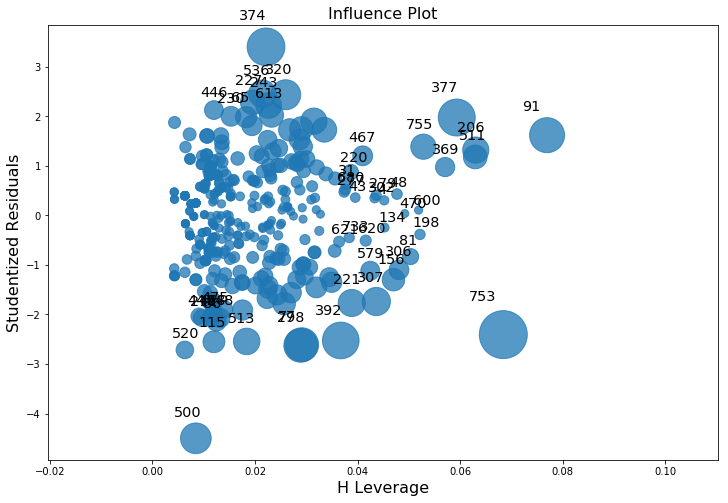

In [50]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")

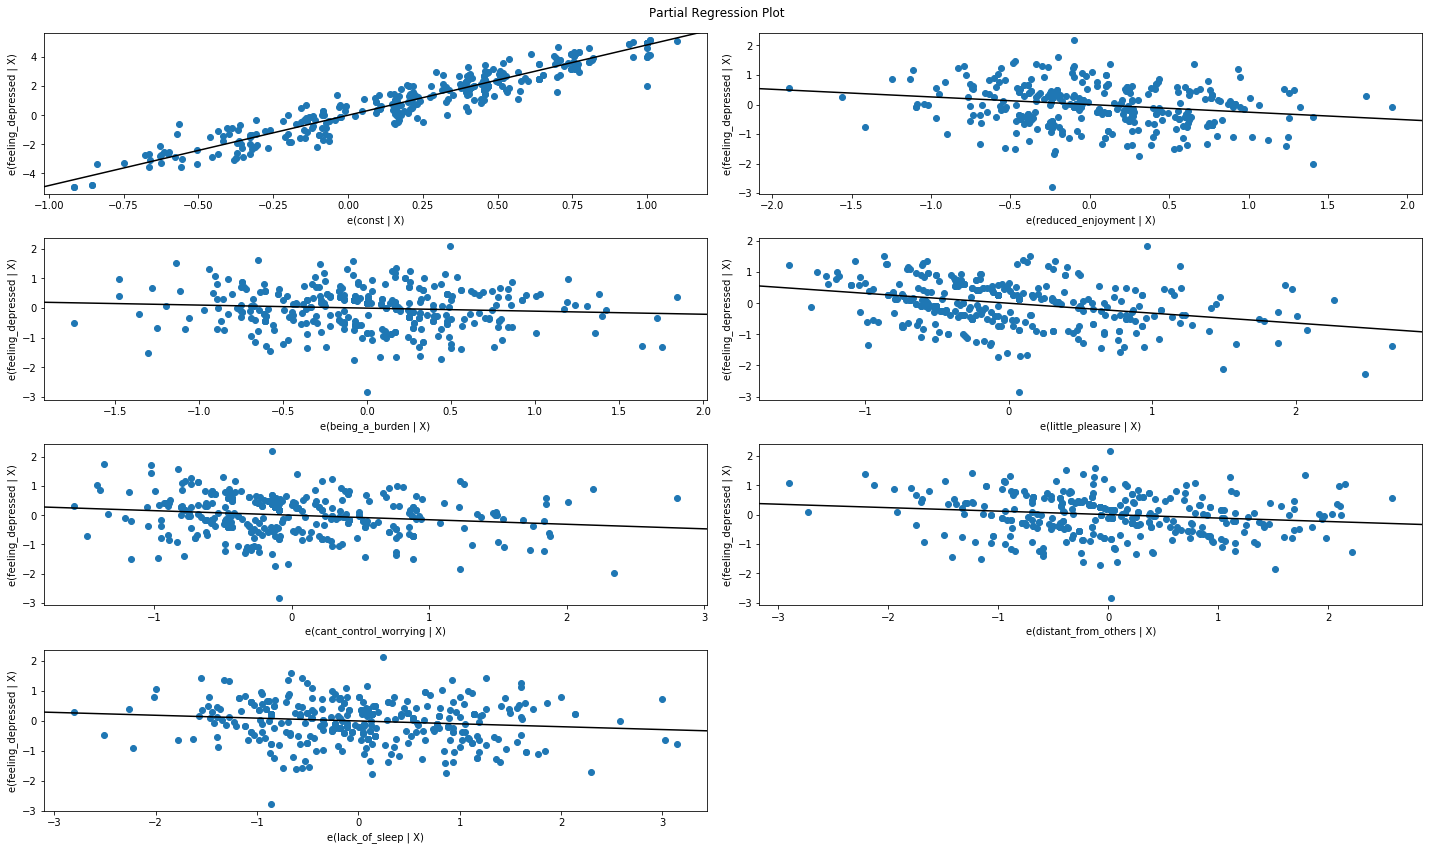

In [51]:
fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)
#plt.savefig('grid.png')
#plt.savefig('grid.pdf')